In [ ]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

base_data_path = 'Data\\Dataset'

In [1]:
import os
import sys
import importlib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

sys.path.append(os.path.join(project_path, 'EMIT-ECOSTRESS\\modules'))
from utils.pickling import join_path, pickle_save, pickle_load
import datasets.Datasets
import models.Feedforward
import utils.train
import utils.eval

In [44]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [46]:
# load data

emit_train = pickle_load(
    project_path,
    # os.path.join(base_data_path, 'Raw\\reflectance_train.pkl')
    os.path.join(base_data_path, 'PCA\\reflectance_train_pca244.pkl')
    # os.path.join(base_data_path, 'AE\\dim_32_train.pkl')
)
emit_val = pickle_load(
    project_path,
    # os.path.join(base_data_path, 'Raw\\reflectance_val.pkl')
    os.path.join(base_data_path, 'PCA\\reflectance_val_pca244.pkl')
    # os.path.join(base_data_path, 'AE\\dim_32_val.pkl')
)

elev_train = pickle_load(
    project_path,
    os.path.join(base_data_path, 'Non-Ref\\elevation_train.pkl')
)
elev_val = pickle_load(
    project_path,
    os.path.join(base_data_path, 'Non-Ref\\elevation_val.pkl')
)

elev_train = (
    (
        elev_train - np.mean(np.concatenate([elev_train, elev_val], axis=1))
    ) / 
    np.std(np.concatenate([elev_train, elev_val], axis=1))
)
elev_val = (
    (
        elev_val - np.mean(np.concatenate([elev_train, elev_val], axis=1))
    ) / 
    np.std(np.concatenate([elev_train, elev_val], axis=1))
)
eco_train = pickle_load(
    project_path,
    os.path.join(base_data_path, 'Non-Ref\\temp_train.pkl')
)
eco_val = pickle_load(
    project_path,
    os.path.join(base_data_path, 'Non-Ref\\temp_val.pkl')
)

In [47]:
r_n_list = [
    (0, 4)
]

len(r_n_list)

1

radius=3, n_components=8
 MiniDenseNN(
  (linear1): Linear(in_features=441, out_features=4, bias=True)
  (linear_output): Linear(in_features=4, out_features=1, bias=True)
  (layernorm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  0.93886,  2.7849   	 Val (RMSE, K):  0.9267,  2.4839   	LR:  0.001	Time: 33.6
Epoch 001:     Train (RMSE, K):  0.58268,  1.7284   	 Val (RMSE, K):  0.73616,  1.9732   	LR:  0.001	Time: 69.0
Epoch 002:     Train (RMSE, K):  0.5438,   1.613   	 Val (RMSE, K):  0.82933,  2.2229   	LR:  0.001	Time: 1.04e+02
Epoch 003:     Train (RMSE, K):  0.51947,  1.5409   	 Val (RMSE, K):  1.1032,  2.9569   	LR:  0.001	Time: 1.41e+02
Epoch 004:     Train (RMSE, K):  0.50737,   1.505   	 Val (RMSE, K):  1.2686,  3.4005   	LR:  0.001	Time: 1.77e+02
Epoch 005:     Train (RMSE, K):  0.49823,  1.4779   	 Val (RMSE, K):  1.3287,  3.5616   	LR: 0.0002	Time: 2.14e+02


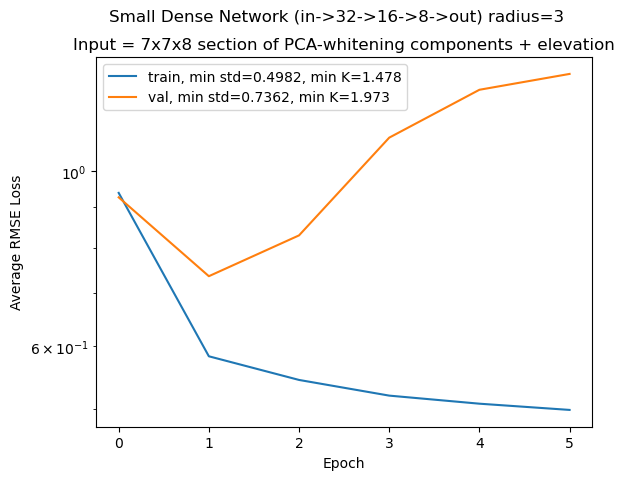

,radius,n_components,train_avg_std,train_std_std,train_std_min,train_std_0.5pct,train_std_2.5pct,train_std_16pct,train_std_25pct,train_std_50pct,...,val_K_0.5pct,val_K_2.5pct,val_K_16pct,val_K_25pct,val_K_50pct,val_K_75pct,val_K_84pct,val_K_97.5pct,val_K_99.5pct,val_K_max
0,3,8,0.498229,0.708335,0.000001,0.002746,0.01385,0.089471,0.140946,0.300164,...,0.016889,0.083204,0.540264,0.859658,1.845729,3.275224,4.8507,8.953274,9.910911,13.273646


In [49]:
importlib.reload(datasets.Datasets)
importlib.reload(models.Feedforward)
importlib.reload(utils.train)
importlib.reload(utils.eval)

batch_size = 256
val_batch_size = 1024

n_epochs = 5
dropout_rate = 0.0

stats_list = []
train_loss_array_list = []
val_loss_array_list = []
train_loss_list = []
val_loss_list = []

stats = None
try:
    for rn in r_n_list:
        radius, n = rn

        omit_components = 244 - n

        # create datasets and dataloaders

        train_dataset = datasets.Datasets.PatchToPixelDataset(
            emit_data=emit_train,
            omit_components=omit_components,
            ecostress_data=eco_train,
            ecostress_center=None,
            ecostress_scale=None,
            additional_data=(elev_train,),
            radius=radius,
            boundary_width=max(
                [r_n_list[i][0] for i in range(len(r_n_list))]
            ),
        )

        val_dataset = datasets.Datasets.PatchToPixelDataset(
            emit_data=emit_val,
            omit_components=omit_components,
            ecostress_data=eco_val,
            ecostress_center=None,
            ecostress_scale=None,
            additional_data=(elev_val,),
            radius=radius,
            boundary_width=max(
                [r_n_list[i][0] for i in range(len(r_n_list))]
            ),
        )

        if batch_size is not None:
            train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                drop_last=False,
                shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=val_batch_size,
                drop_last=False,
                shuffle=False,
            )
        else:
            train_loader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset, batch_size=batch_size, shuffle=False,
            )
            
        
        model = models.Feedforward.MiniDenseNN(
            input_dim=train_dataset.input_dim,
            radius=radius,
            dropout_rate=dropout_rate,
        )
        
        if device == 'cuda':
            model = model.cuda()

        optimizer = optim.Adam(
            params=model.parameters(), lr=0.001, weight_decay=0, fused=True
        )

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, factor=0.2, patience=2
        )

        loss_fn = nn.MSELoss(reduction='sum')

        print(f'radius={radius}, n_dimensions={n}\n', model)
        
        train_loss, val_loss, eval_stats, train_loss_array, val_loss_array = (
            utils.train.train(
                model,
                optimizer,
                scheduler,
                loss_fn,
                train_loader,
                val_loader,
                n_epochs=n_epochs,
                loss_interval=1,
                # preexisting_losses=[train_loss, val_loss],
                device=device,
            )
        )
        
        try:
            eval_stats = np.concatenate([np.array(rn), eval_stats])
            stats_list.append(eval_stats)
            train_loss_array_list.append(train_loss_array)
            val_loss_array_list.append(val_loss_array)
            train_loss_list.append(train_loss)
            val_loss_array_list.append(val_loss)
        except ValueError:
            break
        
        
        fig, ax = plt.subplots()
        fig.suptitle(
            f'Small Dense Network (in->32->16->8->out) radius={radius}'
        )
        l = 2 * radius + 1
        ax.set_title(
            f'Input = {l}x{l}x{244 - omit_components} section of '
            'PCA-whitening components + elevation'
        )
        ax.semilogy(
            np.arange(len(train_loss)),
            train_loss,
            label=(
                'train, '
                f'min std={min(train_loss):.4}, '
            ),
        )
        ax.semilogy(
            np.arange(len(val_loss)),
            val_loss,
            label=(
                'val, '
                f'min std={min(val_loss):.4}, '
            ),
        )
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Average RMSE Loss')
        ax.legend()
        plt.show(fig)
        
    stats = np.array(stats_list)
    stats_columns = utils.eval.initialize_eval_results().columns.to_list()
    stats = pd.DataFrame(stats, columns=stats_columns)
    stats['radius'] = stats['radius'].astype(int)
    stats['n_components'] = stats['n_components'].astype(int)
        
except KeyboardInterrupt:
    print('Training was interrupted by user')

stats

In [32]:
stats.to_csv(join_path(r'Miscellaneous\linear_benchmarking_ae_temp32r.csv'))

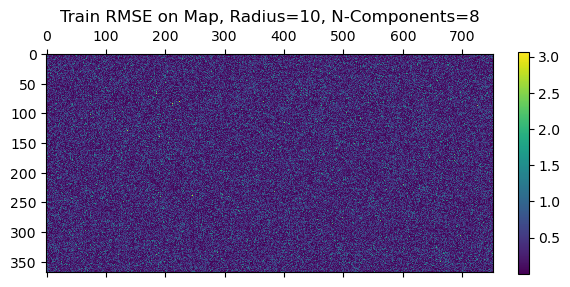

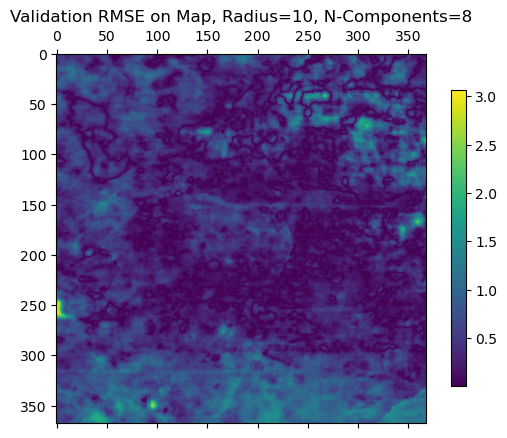

In [33]:
fig, ax = plt.subplots()
ax.set_title('Train RMSE on Map, Radius=10, N-Components=8')
plt.imshow(train_loss_array)
plt.colorbar(fraction=0.05, shrink=0.6)
ax.matshow(train_loss_array)
plt.show(fig)
fig, ax = plt.subplots()
ax.set_title('Validation RMSE on Map, Radius=10, N-Components=8')
plt.imshow(train_loss_array)
plt.colorbar(fraction=0.05, shrink=0.8)
ax.matshow(val_loss_array)
plt.show(fig)